---
format:
  html:
    other-links:
      - text: This notebook
        href: L22-23.ipynb
      - text: preamble.jl
        href: preamble.jl
---


# Pivotted LU Decompositon

::: {.callout-note}

These notes are mainly a record of what we discussed and are not a substitute for attending the lectures and reading books! If anything is unclear/wrong, let me know and I will update the notes. 

::: 

In [1]:
# | code-fold: true

include("preamble.jl")

✓ file included! 

using: Plots, LaTeXStrings, Polynomials, PrettyTables, LinearAlgebra 

functions included: 
    Ch2: simple_iteration, Newton, orderOfConvergence, 
    Ch3: ChebyshevNodes, ChebyshevInterpolant, Lagrange, 

Use @doc <<function>> for help


::: {.callout-note}
## Warm-up

Use LU decomposition combined with forward and backwards substitution to solve the linear system of equations

\begin{align}
\begin{pmatrix}
2 & 3 & 4 \\
4 & 5 & 10 \\
4 & 8 & 2
\end{pmatrix}
\begin{pmatrix}
x\\y\\z
\end{pmatrix}
= \begin{pmatrix}
1 \\ 0 \\ -1
\end{pmatrix}
\end{align}

:::

In [2]:
A = [2 3 4 ; 4 5 10 ; 4 8 2]
lu(A)

LU{Float64, Matrix{Float64}, Vector{Int64}}
L factor:
3×3 Matrix{Float64}:
 1.0  0.0       0.0
 1.0  1.0       0.0
 0.5  0.166667  1.0
U factor:
3×3 Matrix{Float64}:
 4.0  5.0  10.0
 0.0  3.0  -8.0
 0.0  0.0   0.333333

<div class='alert alert-block alert-warning'><b>Exercise.</b> 

What happens when you apply LU decomposition to the following matrix? 

\begin{align}
A = \begin{pmatrix} 2 & 0 & 4 & 3 \\ -2 & 0 & 2 & -13 \\ 1 & 15 & 2 & -4.5 \\ -4 & 5 & -7 & -10 \end{pmatrix}.
\end{align}

The first row of $U$ is $u_1 = (2, 0, 4, 3)$ and so the first row of $L$ is $\ell_1 = (1, -1, 1/2, -2)^\intercal$ (the first column of $A$ divided by $(u_1)_1$). Therefore, we have 

\begin{align}
A^{(2)} := A - \ell_1 u_1 &= \begin{pmatrix} 2 & 0 & 4 & 3 \\ -2 & 0 & 2 & -13 \\ 1 & 15 & 2 & -4.5 \\ -4 & 5 & -7 & -10 \end{pmatrix}
%
- \begin{pmatrix} 2 & 0 & 4 & 3 \\ -2 & 0 & -4 & -3 \\ 1 & 0 & 2 & 3/2 \\ -4 & 0 & -8 & -6 \end{pmatrix} \nonumber\\
%
&= \begin{pmatrix} 0 & 0 & 0 & 0 \\ 0 & 0 & 6 & -10 \\ 0 & 15 & 0 & -6 \\ 0 & 5 & 1 & -4 \end{pmatrix}
\end{align}

Now we have a problem! In the algorithm we learnt last time, we would set $u_2 = (0, 0, 6, -10)$ and then let $\ell_2$ be the second column of $A^{(2)}$ divided by $(u_2)_2$ but this is zero! Instead, we will use a pivoting strategy. This is what the built in function does:

</div> 

In [23]:
A = [ 2 0 4 3 ; -2 0 2 -13 ; 1 15 2 -9/2 ; -4 5 -7 -10 ]

display( lu(A) )

# other examples (we went through some of these)
B = [ 1 2 -3 ; 0 1 -1 ; 1 1 0 ]
C = [0 6 -10 ; 15 0 -6 ; 5 1 -4 ]
D = [ 4 0 8 6 ; -8 10 -14 -20 ; 2 30 4 -9 ; -4 0 4 -26 ];
E = [2 3 4 ; 4 5 10 ; 4 8 2 ]
E \ [6 ; 12 ;7] ;
F = [-2 1 0 0 ; 1 -2 1 0 ; 0 1 -2 1 ; 0 0 1 -2]
lu(F);

LU{Float64, Matrix{Float64}, Vector{Int64}}
L factor:
4×4 Matrix{Float64}:
  1.0    0.0       0.0        0.0
 -0.25   1.0       0.0        0.0
  0.5   -0.153846  1.0        0.0
 -0.5    0.153846  0.0833333  1.0
U factor:
4×4 Matrix{Float64}:
 -4.0   5.0   -7.0      -10.0
  0.0  16.25   0.25      -7.0
  0.0   0.0    5.53846   -9.07692
  0.0   0.0    0.0       -0.166667

## Pivoting

Before, we chose $u_k$ to be the first nonzero row of $A^{(k)}$. Now we instead choose the $p(k)$ row so that we maximise the absolute value of $[A^{(k)}]_{p(k),k}$. Let's consider an example:

Use LU decomposition to solve $Ax = b$ where

\begin{align}\nonumber
A = \begin{pmatrix}
1 & 0 & 2 \\ 0 & 2 & 1 \\ 2 & 0 & 3
\end{pmatrix}.
\end{align}

First, we choose $p(1)$ so that $A_{p(1),1}$ is maximised: that is, $p(1) = 3$. Then, we let $u_1$ be the $p(1)$ row of $A$: that is, $u_1 = (2, 0, 3)$ and $\ell_1$ be the first column of $A$ divided by $(u_1)_1=2$: that is, $\ell_1 = ( 1/2, 0, 1 )^\intercal$. At this stage we have 

\begin{align}\nonumber
L = \begin{pmatrix}
1/2 & \bullet & \bullet \\ 0 & \bullet & \bullet \\ 1 & \bullet & \bullet 
\end{pmatrix}, 
\qquad 
U = \begin{pmatrix}
2 & 0 & 3 \\ \bullet & \bullet & \bullet \\ \bullet & \bullet & \bullet 
\end{pmatrix}, 
\qquad 
p(1) = 3.
\end{align}

Notice that $L$ is no longer going to be lower triangular, but we will fix that at the end (this is why we are tracking the permutation $p$).

Then we consider the matrix $A^{(2)} := A - \ell_1 u_1$ and repeat the same proceedure:

\begin{align}\nonumber
A^{(2)} = \begin{pmatrix}
1 & 0 & 2 \\ 0 & 2 & 1 \\ 2 & 0 & 3
\end{pmatrix} - 
\begin{pmatrix}
1 & 0 & 3/2 \\ 0 & 0 & 0 \\ 2 & 0 & 3
\end{pmatrix}
%
= \begin{pmatrix}
0 & 0 & 1/2 \\ 0 & 2 & 1 \\ 0 & 0 & 0
\end{pmatrix}.
\end{align}

We choose $p(2)$ to maximise $A^{(2)}_{p(2),2}$ and so we set $p(2) = 2$ and $u_2 = (0, 2, 1)$. Then we set $\ell_2$ to be the second column of $A^{(2)}$ divided by $(u_2)_2 = 2$ (that is, $\ell_2 = (0, 1, 0)^\intercal$) and we have 

\begin{align}\nonumber
L = \begin{pmatrix}
1/2 & 0 & \bullet \\ 0 & 1 & \bullet \\ 1 & 0 & \bullet 
\end{pmatrix}, 
\qquad 
U = \begin{pmatrix}
2 & 0 & 3 \\ 0 & 2 & 1 \\ \bullet & \bullet & \bullet 
\end{pmatrix}, 
\qquad 
p(1) = 3, p(2) = 2
\end{align}

Then we consider the matrix $A^{(3)} := A^{(2)} - \ell_2 u_2$ and repeat the same proceedure:

\begin{align}\nonumber
A^{(3)} = \begin{pmatrix}
0 & 0 & 1/2 \\ 0 & 2 & 1 \\ 0 & 0 & 0
\end{pmatrix} - 
\begin{pmatrix}
0 & 0 & 0 \\ 0 & 2 & 1 \\ 0 & 0 & 0
\end{pmatrix}
%
= \begin{pmatrix}
0 & 0 & 1/2 \\ 0 & 0 & 0 \\ 0 & 0 & 0
\end{pmatrix}
\end{align}

and conclude 

\begin{align}\nonumber
L = \begin{pmatrix}
1/2 & 0 & 1 \\ 0 & 1 & 0 \\ 1 & 0 & 0 
\end{pmatrix}, 
\quad 
U = \begin{pmatrix}
2 & 0 & 3 \\ 0 & 2 & 1 \\ 0 & 0 & 1/2 
\end{pmatrix}, 
\quad 
p(1) = 3, p(2) = 2, p(3)=1
\end{align}

Now, we want to solve $A x = b$. Notice that 

\begin{align}\nonumber
PL = \big( L_{p(i),j} \big) = \begin{pmatrix}
1 & 0 & 0 \\ 0 & 1 & 0 \\ 1/2 & 0 & 1  
\end{pmatrix}
\end{align}

is lower triangular (where $P$ is the permutation matrix with a $1$ in the $(i,p(i))$ entry), and so we have 

\begin{align}
(PL) U = Pb
\end{align}

which we may solve using forwards and backwards substitution as before.

<div style='background-color: #cce0ff; padding: 10px; border-left: 5px solid #0066ff;'><strong>Example.</strong> 

Use the PLU decomposition as above to solve 

\begin{align}
\begin{pmatrix}
1 & 0 & 2 \\ 0 & 2 & 1 \\ 2 & 0 & 3
\end{pmatrix} \begin{pmatrix} x\\y\\z\end{pmatrix} = \begin{pmatrix}0\\1\\-1\end{pmatrix}
\end{align}

</div> 

## Why use the largest pivot?

Answer: We get better conditioning by choosing the largest pivot. Later, we introduce the condition number of a matrix, written $\kappa(A)$, which will make the following discussion rigorous. 

Suppose we have the matrix 

\begin{align}
M(\epsilon )= \begin{pmatrix}
-\epsilon & 1 \\
1 & -1
\end{pmatrix}
\end{align}

with $\epsilon \ll 1$. 

1. It turns out that this matrix is well condtitioned for all small $\epsilon$. Here, we can see the condition number is bounded for all small $\epsilon$:

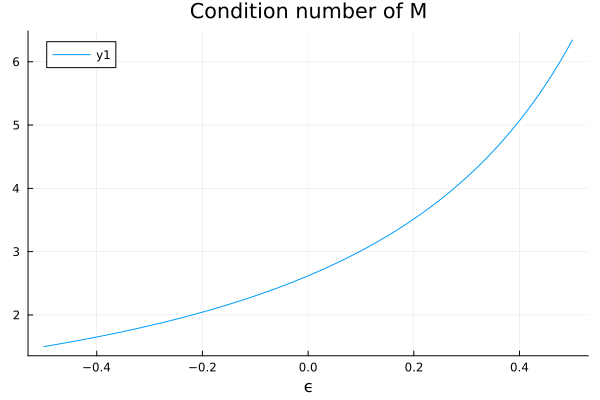

In [5]:
M(ϵ) = [-ϵ 1; 1 -1]
plot( ϵ->cond(M(ϵ)), -1/2, 1/2, title="Condition number of M", xlabel="ϵ")

2. If we did not use pivoting, the LU decompositon of $M(\epsilon)$ is 

\begin{align}
\begin{pmatrix}
1 & 0 \\ -\epsilon^{-1} & 1
\end{pmatrix}
\begin{pmatrix}
-\epsilon & 1 \\ 0 & \epsilon^{-1}-1
\end{pmatrix}
\end{align}

Both of these matrices are illconditioned. In the following, we can see that the condition numbers explode near $\epsilon \approx 0$. 

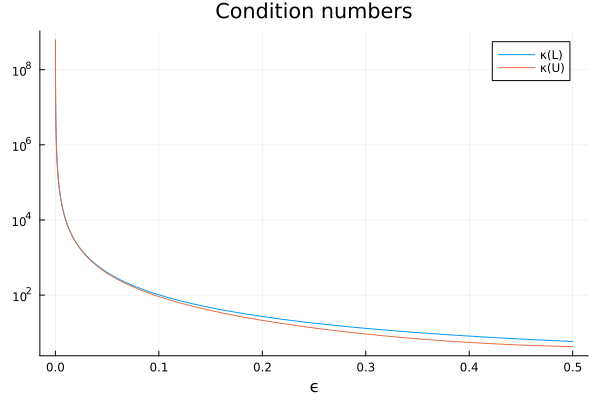

In [19]:
plot( ϵ->cond([1 0 ; -1/ϵ 1 ]), 0, 1/2, yaxis = :log10, title="Condition numbers", xlabel="ϵ", label="κ(L)")
plot!( ϵ->cond([-ϵ 1; 0 -1+1/ϵ]), 0, 1/2, label="κ(U)")

Notice this is not a problem with $M(\epsilon)$, but with our choice of LU decomposition. That is, without pivoting, our algorithm is unstable.

3. Using PLU decomposition, we arrive at 

\begin{align}
LU = \begin{pmatrix} -\epsilon & 1 \\ 1 & 0 \end{pmatrix} \begin{pmatrix} 1 & -1 \\ 0 & 1-\epsilon \end{pmatrix} 
\end{align}

(with $p(1) = 2$ and $p(2) = 1$). These factors are again perfectly conditioned:


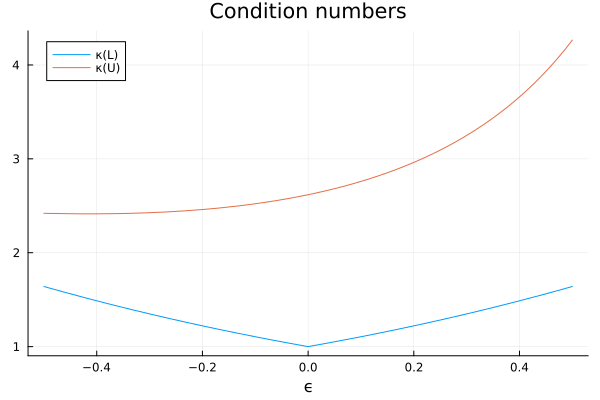

In [22]:
plot( ϵ->cond([-ϵ 1 ; 1 0 ]), -1/2, 1/2, title="Condition numbers", xlabel="ϵ", label="κ(L)")
plot!( ϵ->cond([1 -1; 0 1-ϵ]), -1/2, 1/2, label="κ(U)")

## Condition numbers of linear systems of equations

In order to fully understand the previous section, we need to make sense of the condition number $\kappa(A)$. Recall that when we were considering functions $f : \mathbb R \to \mathbb R$, the condition number was (approximately) the constant of proportionality between the relative error in the input to the relative error of the output. That is, if $x \approx \tilde{x}$ then, we have 

\begin{align}
\frac{|f(x)- f(\tilde{x})|}{|f(x)|} \approx \kappa_f(x) \frac{|x- \tilde{x}|}{|x|}.
\end{align}

We now take this idea but the "input" is the vector $b$ and the "output" is $x$ solving the linear system $A x = b$. Again, the condition number measures how sensitive the solution $x$ is to errors in the data $b$. Roughly speaking, if the condition number is $10^\rho$, we expect to lose $\rho$ digits of accuracy when we go from $b$ to $x$. This made perfect sense on $\mathbb R$ (with the absolute value) but now we have many choices for the norm. We shall fix the Euclidean norm for the remainder of the course:

\begin{align}
|x| := \sqrt{\sum_{j=1}^n |x_j|^2}.
\end{align}

We also need the corresponding *operator norm* on the space of matrices:

\begin{align}
\|A\| := \max_{x\not=0} \frac{|Ax|}{|x|}. 
\end{align}

Notice that, we have $|Ax| \leq \|A\| |x|$ for all $x$. We are now ready to define the condition number of the matrix $A$ (or the corresponding linear system).

Suppose we have the exact data $b$ and exact solution $x$ (solving $Ax=b$) and we have the approximate data $\tilde{b}$ (for example, the floating point representation of $b$) and corresponding solution $\tilde{x}$ solving $A\tilde{x} = \tilde{b}$. First, notice that $|b| = |Ax| \leq \|A\| |x|$ and that $A(x - \tilde{x}) = b - \tilde{b}$ and so

\begin{align}
|x - \tilde{x}| \leq \|A^{-1}\| |b - \tilde{b}|.
\end{align}

Therefore, we have 

\begin{align}
\frac
{|x-\tilde{x}|/|x|}
{|b-\tilde{b}|/|b|}
%
\leq \frac
{|x-\tilde{x}|}
{|b-\tilde{b}|}
\frac
{|b|}
{|x|}
%
\leq \|A^{-1}\| \|A\| 
\end{align}

We call the right hand side the condition number: $\kappa(A) := \|A^{-1}\| \|A\|$.

<div class='alert alert-block alert-warning'><b>Exercise.</b> 

1. Use the definitions directly to show that the following matrices are ill-conditioned,

\begin{align}
\begin{pmatrix}
1 & 0 \\ -\epsilon^{-1} & 1
\end{pmatrix}, 
\begin{pmatrix}
-\epsilon & 1 \\ 0 & \epsilon^{-1}-1
\end{pmatrix}
\end{align}

2. Show that $\|A\| = \max_{|x|=1} |Ax|$, 
3. Show that $\|AB\| \leq \|A\|\|B\|$ and hence $\|A^k\| \leq \|A\|^k$, 
4. What is $\|D\|$ for diagonal $D$,
5. $A$ is normal (i.e. $A^TA = AA^T$) if and only if there exists orthogonal $P$ (i.e. $P^{-1} = P^T$) and diagonal $\Lambda$ such that $A = P\Lambda P^T$. Show that the columns of $P$ are eigenvectors of $A$,
6. Show that, for normal matrices $A$, the operator norm $\|A\|$ is equal to $\max_i |\lambda_i|$ where $(\lambda_i)$ are the eigenvalues of $A$.

</div> 